In [1]:
from PIL import Image,  ImageDraw
import numpy as np
import math
import heapq
import matplotlib.pyplot as plt
from Kalman import ekf
import time

In [3]:
import tdmclient.notebook
await tdmclient.notebook.start()

# Global Map 

In [3]:
map = "./img/map2.png"

In [4]:
def convert_image_to_binary_array(image_path,target_size=(1091, 772)):
    # Load the image
    image = Image.open(image_path)

    resized_image = image.resize(target_size)

    # Convert the image to grayscale
    resized_image = resized_image.convert("L")

    # Set the binary threshold
    binary_threshold = 128

    # Convert grayscale to binary image
    bw_image = resized_image.point(lambda p: p < binary_threshold and 1)

    # Convert image to numpy array
    binary_matrix = np.array(bw_image)
    return binary_matrix , resized_image

In [5]:
class NODE:
    def __init__(self, position, g=float('inf'), h=0, parent=None):
        self.position = position
        self.g = g
        self.h = h
        self.f = g + h
        self.parent = parent

    # Nodes will be compared based on their f value, we use this because of the heapq
    def __lt__(self, other):
        return self.f < other.f

    # Function to represent the node
    def __repr__(self):
        return f"Node(position={self.position}, g={self.g}, h={self.h}, f={self.f})"

    @staticmethod
    def reconstruct_path(node):
        path = []
        while node:
            path.append(node.position)
            node = node.parent
        return path[::-1]


# Heuristic function using Octile distance (allowing 8 directions of movement)
def Heuristic_function(node, goal):
    dx = abs(node.position[0] - goal.position[0])
    dy = abs(node.position[1] - goal.position[1])
    return max(dx, dy) + (math.sqrt(2) - 1) * min(dx, dy)

def A_star(environment_map, START_POSITION, GOAL_POSITION):

    START_NODE = NODE(START_POSITION, g=0)
    GOAL_NODE = NODE(GOAL_POSITION)

    START_NODE.h = Heuristic_function(START_NODE, GOAL_NODE)
    START_NODE.f = START_NODE.g + START_NODE.h

    # Initialize the open and closed lists
    OPEN_list = []
    heapq.heappush(OPEN_list, START_NODE)
    CLOSED_set = set()

    # Dictionary to keep track of nodes
    nodes = {}
    nodes[tuple(START_NODE.position)] = START_NODE

    while OPEN_list:
        # Pop the node with the lowest f value
        CURRENT_NODE = heapq.heappop(OPEN_list)

        # If the current node is in the closed set, skip it
        if tuple(CURRENT_NODE.position) in CLOSED_set:
            continue

        # Add the current node's position to the closed set
        CLOSED_set.add(tuple(CURRENT_NODE.position))

        # If the current node is the goal, reconstruct the path
        if CURRENT_NODE.position == GOAL_NODE.position:
            path = NODE.reconstruct_path(CURRENT_NODE)
            print("Path found:", path)
            return path

        # Possible moves: 8 directions (including diagonals)
        MOVES = [[1, 0], [0, 1], [-1, 0], [0, -1],
                 [1, 1], [-1, -1], [1, -1], [-1, 1]]

        # Explore neighbors
        for move in MOVES:
            neighbor_position = [CURRENT_NODE.position[0] + move[0],
                                 CURRENT_NODE.position[1] + move[1]]
            neighbor_pos = tuple(neighbor_position)

            # Skip if out of bounds or obstacle
            if (neighbor_position[0] < 0 or neighbor_position[0] >= environment_map.shape[0] or
                neighbor_position[1] < 0 or neighbor_position[1] >= environment_map.shape[1] or
                environment_map[neighbor_position[0], neighbor_position[1]] == 1):
                continue

            # Skip if in closed set
            if neighbor_pos in CLOSED_set:
                continue

            # Calculate movement cost (diagnoal movement cost is sqrt(2))
            dx = abs(move[0])
            dy = abs(move[1])
            movement_cost = math.sqrt(2) if dx == 1 and dy == 1 else 1

            g_tentative = CURRENT_NODE.g + movement_cost

            # Create or get the neighbor node
            if neighbor_pos not in nodes:
                neighbor_node = NODE(neighbor_position)
                nodes[neighbor_pos] = neighbor_node
            else:
                neighbor_node = nodes[neighbor_pos]

            # If this path to neighbor is better, record it
            if g_tentative < neighbor_node.g:
                neighbor_node.g = g_tentative
                neighbor_node.h = Heuristic_function(neighbor_node, GOAL_NODE)
                neighbor_node.f = neighbor_node.g + neighbor_node.h
                neighbor_node.parent = CURRENT_NODE

                # Add the neighbor to the open list
                heapq.heappush(OPEN_list, neighbor_node)

    print("No path found.")
    return None

In [6]:
binary_matrix , resized_image = convert_image_to_binary_array(map)
# Start and goal positions
START_POSITION = [5, 5]
GOAL_POSITION = [760, 1080]

path = A_star(binary_matrix, START_POSITION, GOAL_POSITION)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jcarr\\OneDrive\\Documents\\Travail\\EPFL\\MA1\\Basics of mobile robotics\\Exercises8\\Project\\img\\map2.png'

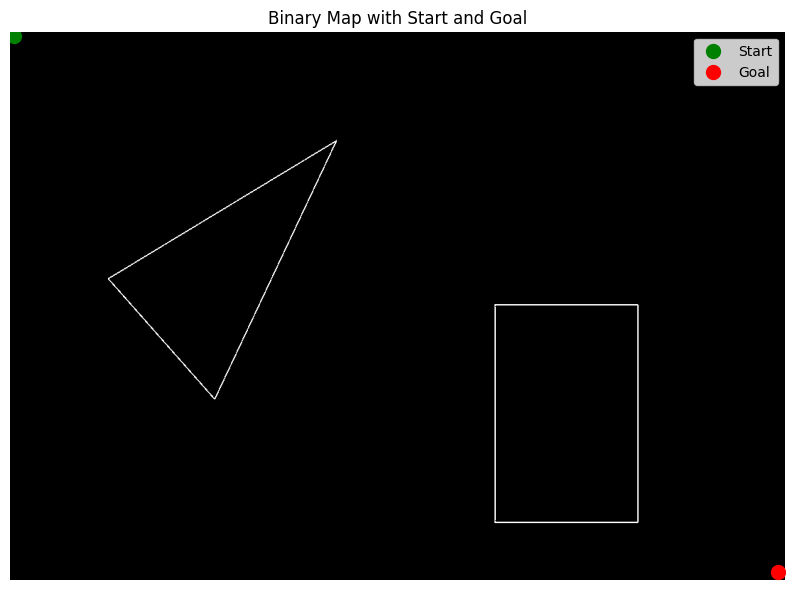

In [ ]:
# Display the binary map with start and goal points
plt.figure(figsize=(10, 10))
plt.imshow(binary_matrix, cmap="gray")
plt.scatter(START_POSITION[1], START_POSITION[0], color='green', s=100, label="Start")  # Green for Start
plt.scatter(GOAL_POSITION[1], GOAL_POSITION[0], color='red', s=100, label="Goal")  # Red for Goal
plt.title("Binary Map with Start and Goal")
plt.legend()
plt.axis("off")
plt.show()


PIL and Matplotlib have different systems of coordinates. Pillow treats the top-left corner as (0,0), and coordinates increase downwards and rightwards.While for Matplotlib displays images as NumPy arrays, where the origin is at the bottom-left corner, and the y-axis is flipped compared to Pillow.

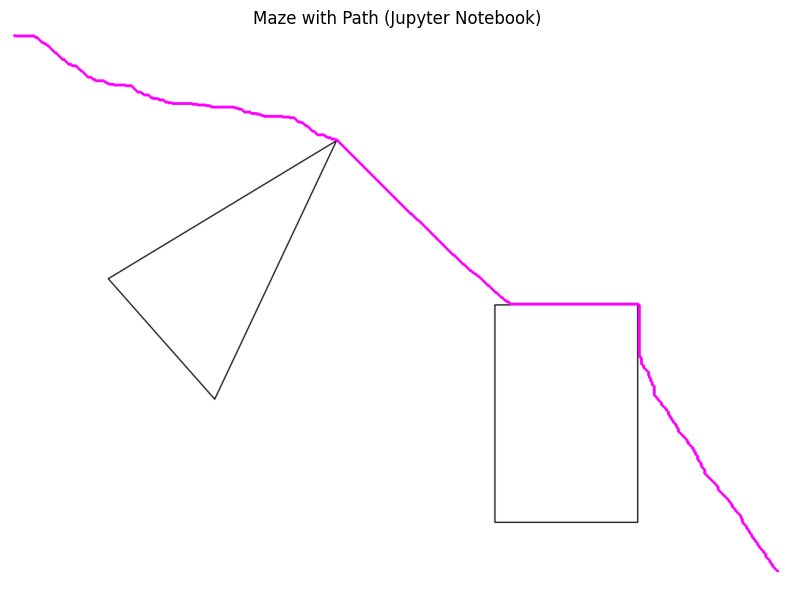

In [ ]:
def swap_path_coordinates(path_coordinates):
    swapped_path = [[y, x] for x, y in path_coordinates]
    return swapped_path

def display_path(maze_img, path):

    # Convert the maze image to RGB (to draw in color)
    maze_img = maze_img.convert("RGB")

    # Swap path coordinates to match PIL's (x, y) format
    path = swap_path_coordinates(path)

    # Create a drawing object
    draw = ImageDraw.Draw(maze_img)

    # Draw the path (magenta line)
    for i in range(len(path) - 1):
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        draw.line((x1, y1, x2, y2), fill=(255, 0, 255), width=4)  # Magenta line with width 4

    # Save the modified image (optional)
    #maze_img.save("maze_with_path_fixed.png")

    # Display the image using Matplotlib
    maze_array = np.array(maze_img)  # Convert to NumPy array for Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(maze_array)
    plt.axis("off")
    plt.title("Maze with Path (Jupyter Notebook)")
    plt.show()

display_path(resized_image, path)

In [ ]:
def segment_path(path, step=10):
    """
    Segments the A* path into waypoints for the motion controller.

    Parameters:
    - path: List of (row, column) points from the A* algorithm.
    - step: Number of points to skip between waypoints.

    Returns:
    - waypoints: List of (x, y) waypoints in meters.
    """
    waypoints = path[::step]  # Take every `step`-th point
    waypoints.append(path[-1])  # Ensure the last point (goal) is included
    return waypoints

def grid_to_world_coordinates(waypoints, map_resolution, origin=(0, 0)):
    """
    Converts waypoints from grid coordinates to world coordinates.

    Parameters:
    - waypoints: List of (row, col) waypoints in grid coordinates.
    - map_resolution: Size of each grid cell in meters.
    - origin: World coordinates of the grid's (0, 0).

    Returns:
    - world_waypoints: List of (x, y) waypoints in meters.
    """
    world_waypoints = [
        (origin[0] + w[1] * map_resolution, origin[1] + w[0] * map_resolution) for w in waypoints
    ]
    return world_waypoints


In [ ]:
waypoints = segment_path(path, step=40) 
map_resolution = 0.05  
origin = (0, 0)
world_waypoints = grid_to_world_coordinates(waypoints, map_resolution, origin)

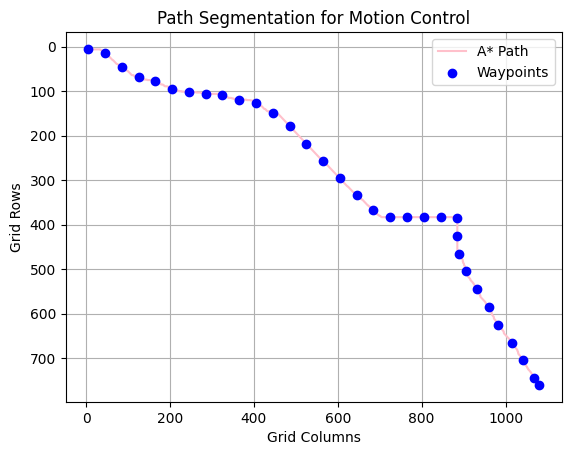

In [ ]:
path = np.array(path)
plt.plot(path[:, 1], path[:, 0], label="A* Path", color="pink")

waypoints = np.array(waypoints)
plt.scatter(waypoints[:, 1], waypoints[:, 0], color="blue", label="Waypoints", zorder=3)

plt.gca().invert_yaxis()  
plt.legend()
plt.title("Path Segmentation for Motion Control")
plt.xlabel("Grid Columns")
plt.ylabel("Grid Rows")
plt.grid()
plt.show()


# Motion Control 

## Testing some things on thymio: 

In [4]:
!pip install --upgrade tdmclient

In [6]:
# Robot-specific constants
ROBOT_CENTER_TO_WHEEL = 47.5  # Half the wheelbase mm
ROBOT_WHEEL_RADIUS = 22    # Radius of the wheels mm
SPEED_THRESHOLD = 100         # Max Thymio wheel speed

# Normalize angle to (-pi, pi)
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Astolfi Controller for Thymio
def astolfi_controller(state, goal, kr= 0.8, ka=  1.2,  goal_tolerance=20):
    #alpha doit etre plus grand que rho pour Julien 
    
    x = state[0] #en mm 
    y = state[1] #en mm 
    theta = state[2]
    x_goal, y_goal = goal
    dx = x_goal - x
    dy = y_goal - y
    rho = np.sqrt(dx**2 + dy**2)  # Distance to goal

    print ("Distance to goal = " , rho )
    alpha = normalize_angle(np.arctan2(dy, dx) - theta)
    #beta = normalize_angle(- theta - alpha)
    # Stop if the robot is close enough to the goal
    if rho < goal_tolerance:
        return 0.0, 0.0, True
    # Control laws
    v = kr * rho #kr > 0 
    #v = max(kr * rho, MIN_SPEED) 
    omega = ka * alpha 
    return v, omega, False


# Convert velocities to motor speeds
def compute_motor_speeds(v, omega):

    # Convert speed thresholds for clipping
    max_v = SPEED_THRESHOLD * 0.388  # Max linear velocity in mm/s
    max_omega = max_v / ROBOT_CENTER_TO_WHEEL  # Max angular velocity in rad/s

    v = np.clip(v, -max_v, max_v) #actul control velocity given to the thymio 
    omega = np.clip(omega, -max_omega, max_omega)

    right_wheel_mm_s = (v + omega * ROBOT_CENTER_TO_WHEEL)  # mm/s
    left_wheel_mm_s = (v - omega * ROBOT_CENTER_TO_WHEEL)  # mm/s

    thymio_speed_to_mms = 0.388
    right_wheel_enc = np.clip(right_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)
    left_wheel_enc = np.clip(left_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)

    # Debugging outputs
    #print(f"Clipped control inputs: v = {v}, omega = {omega}")
    #print(f"left wheel control speed = {left_wheel_enc}, right wheel control speed = {right_wheel_enc}")

    return int(left_wheel_enc), int(right_wheel_enc) , v , omega 


## TEST 

In [7]:
#fonctions de Julie 
@tdmclient.notebook.sync_var 
def set_speed(right_speed,left_speed):
    global motor_right_target, motor_left_target
    motor_right_target=right_speed
    motor_left_target=left_speed

@tdmclient.notebook.sync_var
def stop_thymio():
    global motor_right_target,motor_left_target
    motor_right_target=0
    motor_left_target=0

@tdmclient.notebook.sync_var
def get_speed():
    global motor_right_speed, motor_left_speed
    return motor_right_speed,motor_left_speed

def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation

    #odometry 
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation
    
    difference_speed = l_speed - r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega


In [8]:
def move_to_waypoint(state, waypoint, goal_tolerance=20):
    # Astolfi controller to compute control signals
    v, omega, reached = astolfi_controller(state, waypoint, goal_tolerance=goal_tolerance)
    if reached:
        return 0, 0, True , 0 ,0
    # Convert control signals to motor speeds
    left_speed, right_speed ,v_f , omega_f = compute_motor_speeds(v, omega)
    return left_speed, right_speed, False , v_f , omega_f  #in Thymio's units 


In [12]:
stop_thymio()

In [11]:
#pour tester
#waypoints = [(70, 300), (98, 236), (126, 172), (153, 107), (181, 43), (209, -21), (237, -85), (265, -150), (293, -214), (320, -278), (348, -342), (376, -407), (404, -471), (432, -535), (460, -599)]

waypoints =  [
    (0.0, 0.0),
    (69.7, 1.6),
    (138.2, 13.1),
    (204.1, 34.2),
    (265.9, 64.3),
    (322.2, 102.5),
    (371.6, 147.6),
    (413.0, 198.3),
    (445.3, 253.3),
    (467.5, 311.2)
]

# Initial state [x, y, theta]
state_est=[0,0,0,0,0] 
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 30

obs_camera=[np.nan,np.nan,np.nan]
camera_state=False

# Logging data
trajectory = []  # To store [x, y] positions
trajectory = []  # Logs (x, y) positions
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal

time_prev = time.time()

# Start motion
for waypoint in waypoints:
    print("Goal" , waypoint)
    reached = False
    while not reached:
        actual_time = time.time()
        Ts = actual_time - time_prev
        if Ts < 0.15:
            time.sleep(0.15-Ts)
        time_prev = actual_time
        # Move towards the waypoint
        input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)

        set_speed(input_right_speed, input_left_speed)
        # Get current odometry data
        r_speed_odo, l_speed_odo = get_speed()
        actual_v = speed_convesion(r_speed_odo, l_speed_odo)
        actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
        obs_odometry = [actual_v, actual_w]

        # Control input
        input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
        input_w = omega_f
        control_vect_prev = [input_v, input_w]

        # Update state with Kalman filter
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
        # Log trajectory
        trajectory.append((state_est[0], state_est[1]))
        
        # Calculate and log metrics
        rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
        alpha = normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
        metrics_rho.append(rho)
        metrics_alpha.append(alpha)
        # Print updated state
        print(f"Position Actuelle odometry: x = {state_est[0]}, y = {state_est[1]}, theta = {state_est[2]}") 

    # Stop the robot at the waypoint
    stop_thymio()
    print(f"Reached waypoint: {waypoint}")

print("Trajectory completed!")


Goal (0.0, 0.0)
Distance to goal =  0.0
Position Actuelle odometry: x = -1.4427441817063557e-05, y = 0.0, theta = -1.3990971343526197e-05
Reached waypoint: (0.0, 0.0)
Goal (69.7, 1.6)
Distance to goal =  69.71837642390705
Clipped control inputs: v = 38.800000000000004, omega = 0.02755857478238557
left wheel control speed = 96.62620540679558, right wheel control speed = 100.0
Position Actuelle odometry: x = 4.871906747027991, y = -0.0001293956717403976, theta = 0.0016114852984804814
Distance to goal =  64.84783796626475
Clipped control inputs: v = 38.800000000000004, omega = 0.027679389648553432
left wheel control speed = 96.61141492704566, right wheel control speed = 100.0
Position Actuelle odometry: x = 4.824909892154702, y = -5.886724631037493e-05, theta = 0.001185904010843014
Distance to goal =  64.89481878300995
Clipped control inputs: v = 38.800000000000004, omega = 0.028167339722293502
left wheel control speed = 96.55167877111099, right wheel control speed = 100.0
Position Actuel

KeyboardInterrupt: 

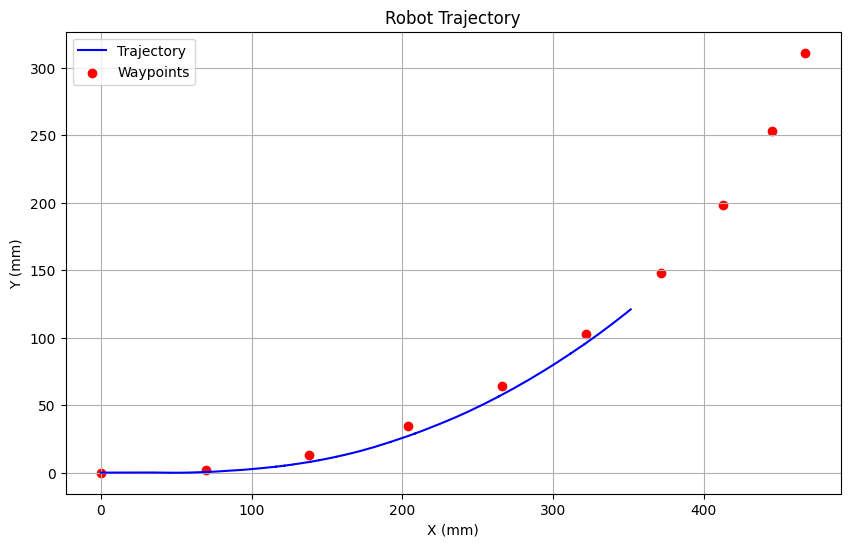

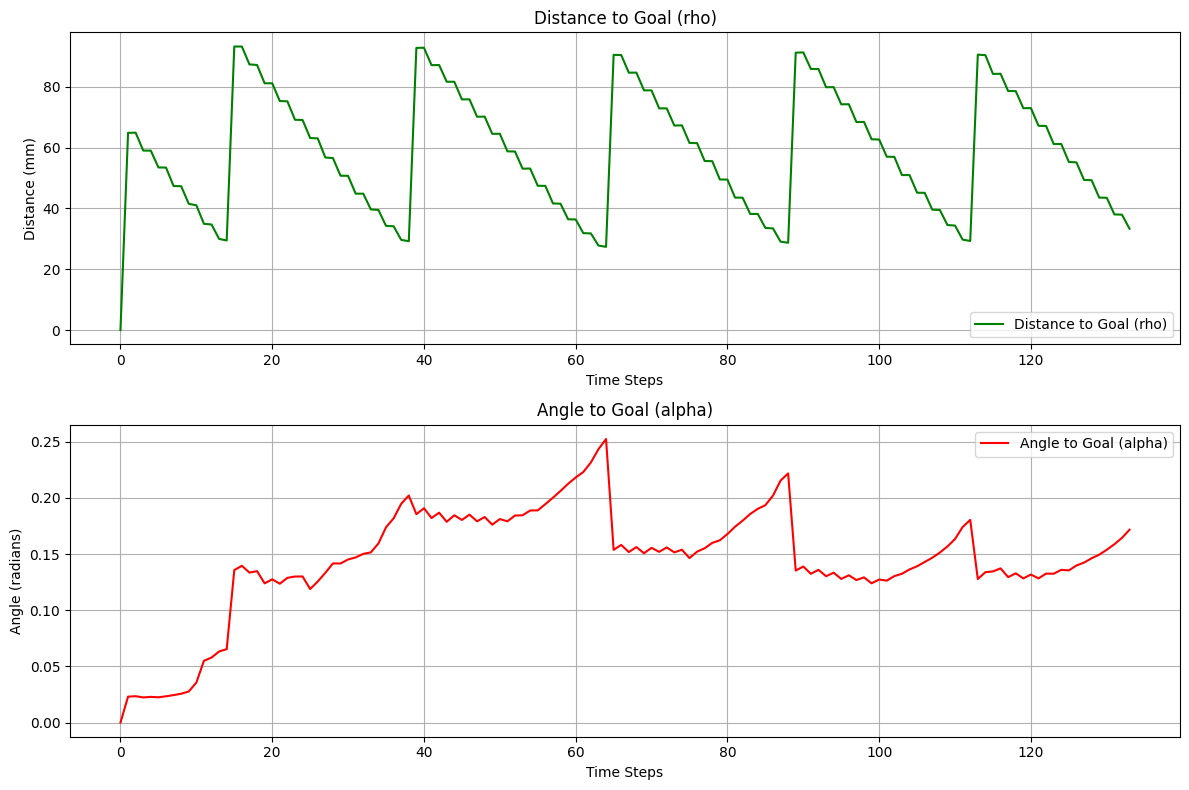

In [13]:
# Plot the robot's final trajectory
plt.figure(figsize=(10, 6))
plt.title("Robot Trajectory")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
x_coords, y_coords = zip(*trajectory)
plt.plot(x_coords, y_coords, 'b-', label="Trajectory")
plt.scatter(*zip(*waypoints), c='r', label="Waypoints")
plt.legend()
plt.grid()
plt.show()

# Plot metrics (rho and alpha) over time
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(metrics_rho, 'g-', label="Distance to Goal (rho)")
plt.xlabel("Time Steps")
plt.ylabel("Distance (mm)")
plt.title("Distance to Goal (rho)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(metrics_alpha, 'r-', label="Angle to Goal (alpha)")
plt.xlabel("Time Steps")
plt.ylabel("Angle (radians)")
plt.title("Angle to Goal (alpha)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [17]:
stop_thymio()

### Adding Simple Local Nav: 

In [9]:
@tdmclient.notebook.sync_var
def get_proximity_values():
    global prox_horizontal
    prox = prox_horizontal
    prox_front = prox[2]
    prox_left = prox[0]
    prox_left_front = prox[1]
    prox_right_front = prox[3]
    prox_right = prox[4]
    return prox_front, prox_left, prox_left_front, prox_right_front, prox_right

In [62]:
stop_thymio()

In [51]:
set_speed(-100,100)

In [63]:
#ligne droite distance 70 mm entre waypoints
""" waypoints =  [
    (0.0, 0.0),
    (69.7, 1.6),
    (138.2, 13.1),
    (204.1, 34.2),
    (265.9, 64.3),
    (322.2, 102.5),
    (371.6, 147.6),
    (413.0, 198.3),
    (445.3, 253.3),
    (467.5, 311.2)
] """
#Straight trajectory 
waypoints = [
    (0.0, 0.0),
    (70.0, 0.0),
    (140.0, 0.0),
    (210.0, 0.0),
    (280.0, 0.0),
    (350.0, 0.0),
    (420.0, 0.0),
    (490.0, 0.0),
    (560.0, 0.0),
    (630.0, 0.0)
]


# Initial state [x, y, theta]
state_est=[0,0,0,0,0] 
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 30

obs_camera=[np.nan,np.nan,np.nan]
camera_state=False

obstSpeedGain = [2, 1, -1, -1.5, -2.5]  # Gains for obstacle avoidance
OBSTACLE_THRESH_LOW_FRONT = 8 # Threshold to stop avoiding
OBSTACLE_THRESH_HIGH_FRONT = 15 # Threshold to start avoiding
thymio_state = 0  # 0 = Goal tracking, 1 = Obstacle avoidance

# Logging data
trajectory = []  # To store [x, y] positions
trajectory = []  # Logs (x, y) positions
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal

#logging pour local nav 
left_speeds = []  # Logs left wheel speeds 
right_speeds = []  # Logs right wheel speeds
proximity_sensor_data = [] 
thymio_modes = []

time_prev = time.time()

# Start motion
for waypoint in waypoints:
    print("GOAL " , waypoint)
    reached = False
    while not reached:
        actual_time = time.time()
        Ts = actual_time - time_prev
        if Ts < 0.15:
            time.sleep(0.15-Ts)
        time_prev = actual_time

        prox_front, prox_left, prox_left_front, prox_right_front, prox_right = get_proximity_values()
        proximity_values = [prox_left, prox_left_front, prox_front, prox_right_front, prox_right]
    
        # Check for obstacle state transitions
        if thymio_state == 0:
        # Switch to obstacle avoidance if an obstacle is detected
            if any((prox // 100) > OBSTACLE_THRESH_HIGH_FRONT for prox in proximity_values) :
                thymio_state = 1
        elif thymio_state == 1:
        # Switch back to goal tracking if obstacles are cleared
            if all((prox // 100) < OBSTACLE_THRESH_LOW_FRONT for prox in proximity_values):
                print("Obstacle avoided")
                #set_speed(20, 20)  #Continue getting away from obstacle for a short time ?   
                #stop_thymio() #idk if i keep it 
                thymio_state = 0
                break #to go to next waypoint
        if thymio_state == 0:
            # Goal tracking
            print("Goal tracking :", waypoint)
             # Move towards the waypoint
            input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)
            set_speed(input_right_speed, input_left_speed)
        else:
            # Obstacle avoidance
            print("Obstacle detected !! ")
            proximity_sensor_data.append(proximity_values) 
           
            spLeft = 40 
            spRight = 40
            if (abs(prox_left_front - prox_right_front) < 20 ) : 
                if prox_left_front >= prox_right_front:
                    # More space on the right, turn right
        
                    spLeft += 40  # Boost left wheel speed to turn right
                    spRight -= 40  # Slow down right wheel speed
                elif  prox_right_front >= prox_left_front:
                    # More space on the left, turn left
                
                    spLeft -= 40  # Slow down left wheel speed
                    spRight += 40  # Boost right wheedl speed
                else: 

                    spLeft += 40  # Boost left wheel speed to turn right
                    spRight -= 40  # Slow down right wheel speed
            else: 
                for i in range(5):
                    spLeft += proximity_values[i] * obstSpeedGain[i] // 100
                    spRight += proximity_values[i] * obstSpeedGain[4 - i] // 100
    
            #time.sleep(0.3) 
            input_left_speed = int(spLeft)
            input_right_speed = int(spRight)
            #left_speeds.append(input_left_speed)  # Append left wheel speed
            #right_speeds.append(input_right_speed)  
            input_right_speed = int(np.clip(input_right_speed, -100, 100))
            input_left_speed = int(np.clip(input_left_speed, -100, 100))
            set_speed(input_right_speed, input_left_speed)
            #time.sleep(0.02)
            print( "PR =" , prox_right//100 , "PRF :" , prox_right_front//100 , "PF : ", prox_front//100)
            print( "PL =" , prox_left//100 , "PLF :" , prox_left_front//100 )
            print("Left Speed OA:", input_left_speed)
            print("Right Speed OA:", input_right_speed)


            #time.sleep(0.15)
        
        # Get current odometry data
        r_speed_odo, l_speed_odo = get_speed()
        actual_v = speed_convesion(r_speed_odo, l_speed_odo)
        actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
        obs_odometry = [actual_v, actual_w]

        # Control input
        input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
        input_w = omega_f
        control_vect_prev = [input_v, input_w]

        # Update state with Kalman filter
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
        # Log trajectory
        trajectory.append((state_est[0], state_est[1]))
        thymio_modes.append(thymio_state)
        
        # Calculate and log metrics
        rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
        alpha = normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
        metrics_rho.append(rho)
        metrics_alpha.append(alpha)
       

    # Stop the robot at the waypoint
    stop_thymio()
    print(f"Reached waypoint: {waypoint}")

print("Trajectory completed!")

GOAL  (0.0, 0.0)
Goal tracking : (0.0, 0.0)
Distance to goal =  0.0
Reached waypoint: (0.0, 0.0)
GOAL  (70.0, 0.0)
Goal tracking : (70.0, 0.0)
Distance to goal =  70.0
Goal tracking : (70.0, 0.0)
Distance to goal =  74.02477124255637
Goal tracking : (70.0, 0.0)
Distance to goal =  74.99349253567443
Goal tracking : (70.0, 0.0)
Distance to goal =  72.6039749051893
Goal tracking : (70.0, 0.0)
Distance to goal =  72.60722971754998
Goal tracking : (70.0, 0.0)
Distance to goal =  66.9733243952241
Goal tracking : (70.0, 0.0)
Distance to goal =  66.88628108547265
Goal tracking : (70.0, 0.0)
Distance to goal =  61.08516134000842
Goal tracking : (70.0, 0.0)
Distance to goal =  60.931159752870535
Goal tracking : (70.0, 0.0)
Distance to goal =  55.221600400570146
Goal tracking : (70.0, 0.0)
Distance to goal =  55.09226969827966
Goal tracking : (70.0, 0.0)
Distance to goal =  49.09078175809698
Goal tracking : (70.0, 0.0)
Distance to goal =  48.889045396108145
Goal tracking : (70.0, 0.0)
Distance to

KeyboardInterrupt: 

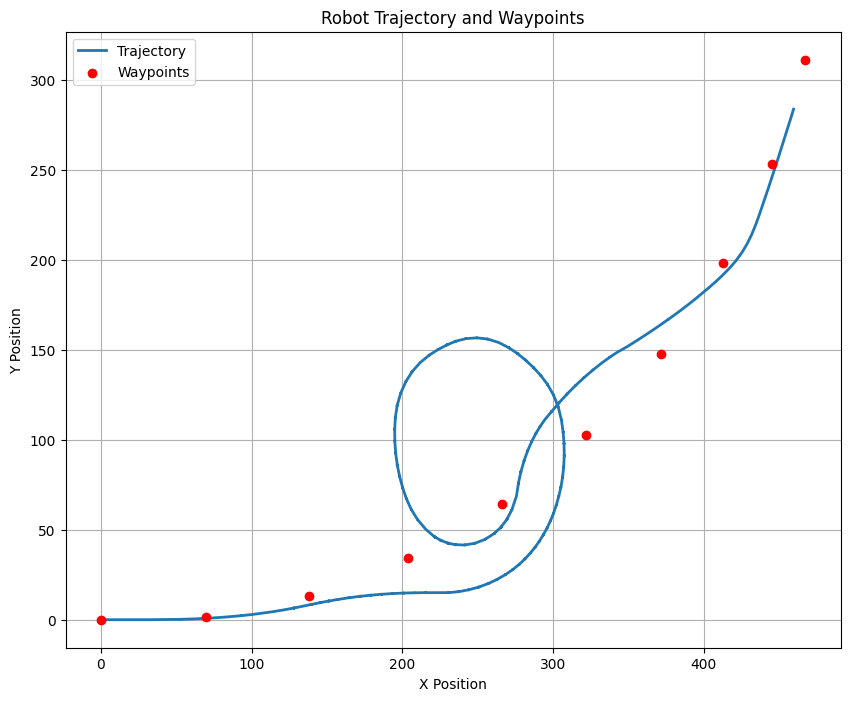

In [65]:
import matplotlib.pyplot as plt

# Extract trajectory and waypoints
x_traj, y_traj = zip(*trajectory)
x_waypoints, y_waypoints = zip(*waypoints)

# Plot
plt.figure(figsize=(10, 8))
plt.plot(x_traj, y_traj, label="Trajectory", linewidth=2)
plt.scatter(x_waypoints, y_waypoints, color='red', label="Waypoints", zorder=5)
plt.title("Robot Trajectory and Waypoints")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid()

plt.show()


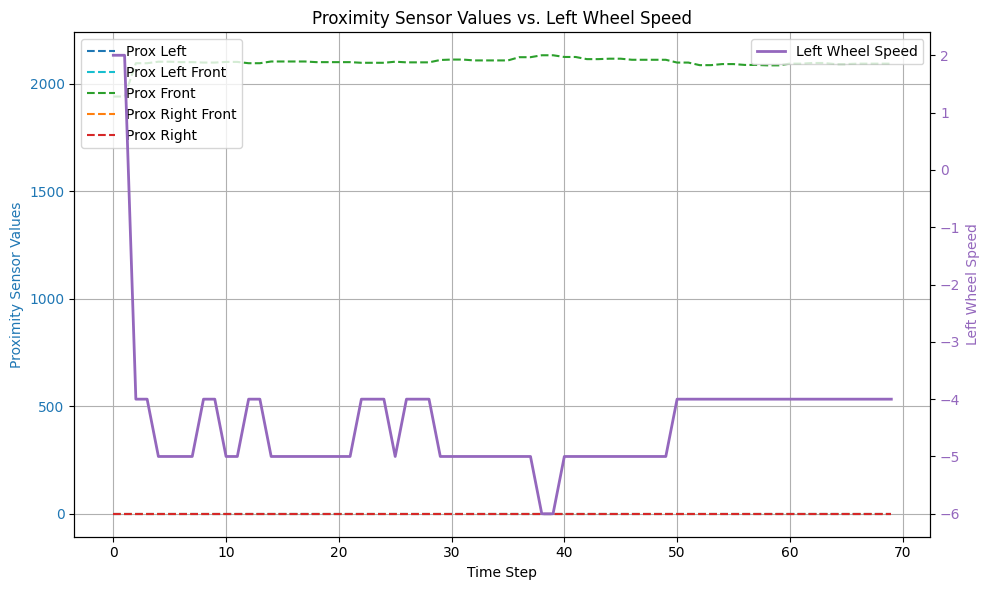

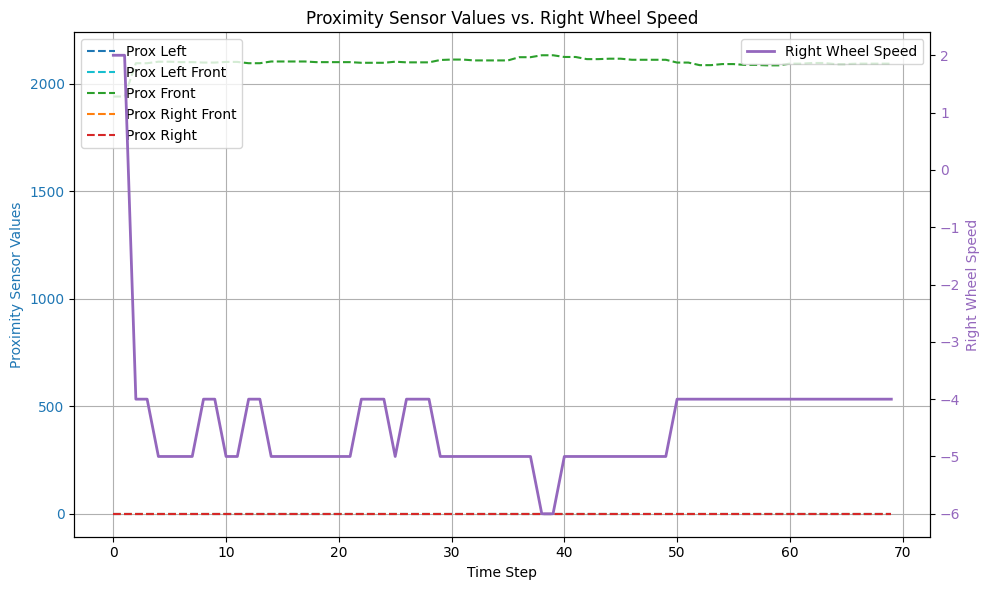

In [144]:

# Convert proximity sensor data into separate lists
prox_left, prox_left_front, prox_front, prox_right_front, prox_right = zip(*proximity_sensor_data)

time_steps = range(len(left_speeds))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis for sensor values
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Proximity Sensor Values", color='tab:blue')
ax1.plot(time_steps, prox_left, label="Prox Left", linestyle='--', color='tab:blue')
ax1.plot(time_steps, prox_left_front, label="Prox Left Front", linestyle='--', color='tab:cyan')
ax1.plot(time_steps, prox_front, label="Prox Front", linestyle='--', color='tab:green')
ax1.plot(time_steps, prox_right_front, label="Prox Right Front", linestyle='--', color='tab:orange')
ax1.plot(time_steps, prox_right, label="Prox Right", linestyle='--', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")
ax1.grid()

# Secondary y-axis for left wheel speed
ax2 = ax1.twinx()
ax2.set_ylabel("Left Wheel Speed", color='tab:purple')
ax2.plot(time_steps, left_speeds, label="Left Wheel Speed", linewidth=2, color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')
ax2.legend(loc="upper right")

# Title and layout
plt.title("Proximity Sensor Values vs. Left Wheel Speed")
fig.tight_layout()
plt.show()


fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary y-axis for sensor values
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Proximity Sensor Values", color='tab:blue')
ax1.plot(time_steps, prox_left, label="Prox Left", linestyle='--', color='tab:blue')
ax1.plot(time_steps, prox_left_front, label="Prox Left Front", linestyle='--', color='tab:cyan')
ax1.plot(time_steps, prox_front, label="Prox Front", linestyle='--', color='tab:green')
ax1.plot(time_steps, prox_right_front, label="Prox Right Front", linestyle='--', color='tab:orange')
ax1.plot(time_steps, prox_right, label="Prox Right", linestyle='--', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")
ax1.grid()

# Secondary y-axis for right wheel speed
ax2 = ax1.twinx()
ax2.set_ylabel("Right Wheel Speed", color='tab:purple')
ax2.plot(time_steps, right_speeds, label="Right Wheel Speed", linewidth=2, color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')
ax2.legend(loc="upper right")

# Title and layout
plt.title("Proximity Sensor Values vs. Right Wheel Speed")
fig.tight_layout()
plt.show()



ValueError: x and y must have same first dimension, but have shapes (70,) and (1,)

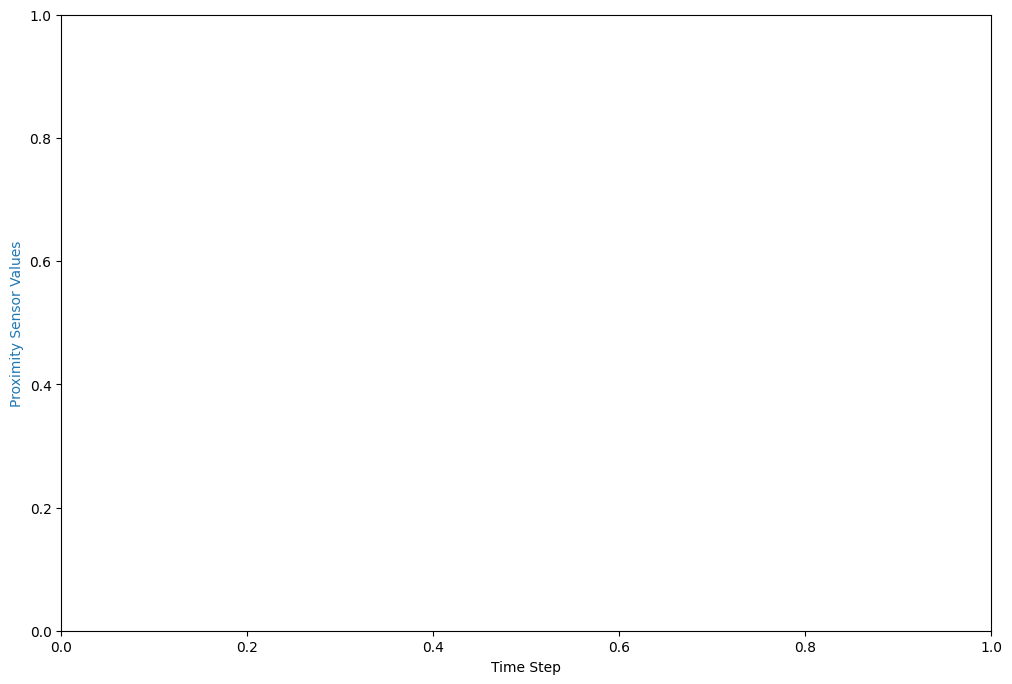

In [157]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# Primary y-axis for sensor values
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Proximity Sensor Values", color='tab:blue')
ax1.plot(time_steps, prox_left, label="Prox Left", linestyle='--', color='tab:blue')
ax1.plot(time_steps, prox_left_front, label="Prox Left Front", linestyle='--', color='tab:cyan')
ax1.plot(time_steps, prox_front, label="Prox Front", linestyle='--', color='tab:green')
ax1.plot(time_steps, prox_right_front, label="Prox Right Front", linestyle='--', color='tab:orange')
ax1.plot(time_steps, prox_right, label="Prox Right", linestyle='--', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")
ax1.grid()

# Secondary y-axis for wheel speeds
ax2 = ax1.twinx()
ax2.set_ylabel("Wheel Speeds", color='tab:purple')
ax2.plot(time_steps, left_speeds, label="Left Wheel Speed", linewidth=2, color='tab:purple')
ax2.plot(time_steps, right_speeds, label="Right Wheel Speed", linewidth=2, color='tab:pink')
ax2.tick_params(axis='y', labelcolor='tab:purple')
ax2.legend(loc="upper right")

# Title and layout
plt.title("Proximity Sensor Values vs. Wheel Speeds")
fig.tight_layout()
plt.show()



In [15]:
stop_thymio()

## simulation calcul thymio pour alpha et beta: 


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Constants for Thymio speed computation
SPEED_THRESHOLD = 100  # Max Thymio speed
ROBOT_CENTER_TO_WHEEL = 47.5  # Distance from the center to each wheel in mm

def compute_motor_speeds(v, omega):
    # Convert speed thresholds for clipping
    max_v = SPEED_THRESHOLD * 0.388  # Max linear velocity in mm/s
    max_omega = max_v / ROBOT_CENTER_TO_WHEEL  # Max angular velocity in rad/s

    v = np.clip(v, -max_v, max_v)  # Actual control velocity given to the Thymio
    omega = np.clip(omega, -max_omega, max_omega)

    right_wheel_mm_s = (v + omega * ROBOT_CENTER_TO_WHEEL)  # mm/s
    left_wheel_mm_s = (v - omega * ROBOT_CENTER_TO_WHEEL)  # mm/s

    thymio_speed_to_mms = 0.388
    right_wheel_enc = np.clip(right_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)
    left_wheel_enc = np.clip(left_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)

    return int(left_wheel_enc), int(right_wheel_enc), v, omega

def astolfi_simulation_with_speeds(initial_state, goal, goal_tolerance, k_alpha, k_rho, time_step=0.15, max_iterations=100):
    # Initialize variables
    x, y, theta = initial_state
    x_goal, y_goal = goal
    trajectory = [(x, y, theta)]  # To store the robot's path
    iterations = 0
    motor_speeds = []  # Store Thymio motor speeds
    times = []  # Store time for plotting
    rho = 0 

    while (iterations < max_iterations) or (rho < 30) :
        # Compute polar coordinates
        dx = x_goal - x
        dy = y_goal - y
        rho = math.sqrt(dx**2 + dy**2)
        alpha = math.atan2(dy, dx) - theta  # Orientation error

        # Normalize alpha to [-pi, pi]
        alpha = (alpha + math.pi) % (2 * math.pi) - math.pi

        # Check if goal is reached
        if rho < goal_tolerance:
            print("Success")
            break

        # Control laws
        v = k_rho * rho  # Linear velocity
        w = k_alpha * alpha  # Angular velocity

        # Compute Thymio motor speeds
        left_speed, right_speed, clipped_v, clipped_omega = compute_motor_speeds(v, w)
        motor_speeds.append((left_speed, right_speed))
        times.append(iterations * time_step)

        # Apply motion model
        x += clipped_v * math.cos(theta) * time_step
        y += clipped_v * math.sin(theta) * time_step
        theta += clipped_omega * time_step

        # Store results
        trajectory.append((x, y, theta))

        # Increment iteration
        iterations += 1

    return iterations, trajectory, motor_speeds, times


Success


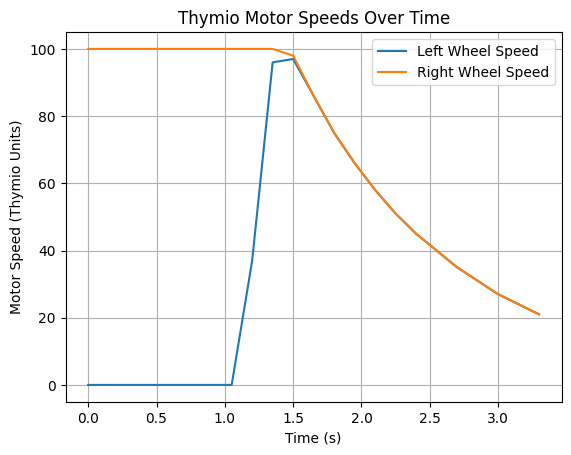

Number of iterations to reach the goal: 23


In [45]:

# Example usage
initial_state = (0, 0, 0)  # Start at origin, facing right
goal = (70,70)   # Goal position
goal_tolerance = 10
k_alpha = 7 
k_rho = 0.8

iterations, trajectory, motor_speeds, times = astolfi_simulation_with_speeds(
    initial_state, goal, goal_tolerance, k_alpha, k_rho
)

# Plot motor speeds
left_speeds = [speed[0] for speed in motor_speeds]
right_speeds = [speed[1] for speed in motor_speeds]

plt.plot(times, left_speeds, label="Left Wheel Speed")
plt.plot(times, right_speeds, label="Right Wheel Speed")
plt.title("Thymio Motor Speeds Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Motor Speed (Thymio Units)")
plt.legend()
plt.grid()
plt.show()

print(f"Number of iterations to reach the goal: {iterations}")



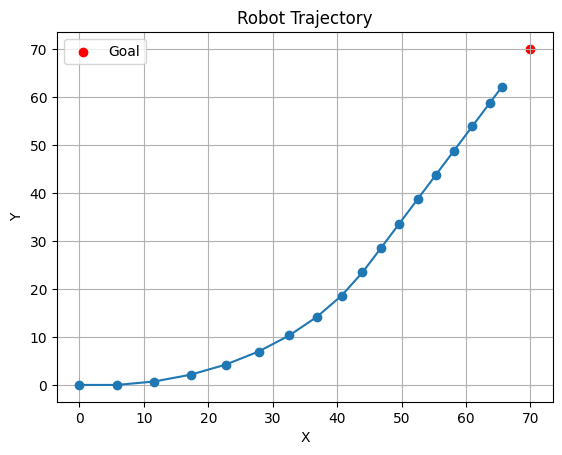

In [39]:
import matplotlib.pyplot as plt

trajectory_x = [pos[0] for pos in trajectory]
trajectory_y = [pos[1] for pos in trajectory]

plt.plot(trajectory_x, trajectory_y, marker="o")
plt.scatter([goal[0]], [goal[1]], color="red", label="Goal")
plt.title("Robot Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

In [14]:
stop_thymio()